In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime, timedelta
from statistics import mode 
from pprint import pprint

In [2]:
data = pd.read_csv('data.csv', sep = ",", dtype = {"fullVisitorID":str})

In [3]:
# Imputación de missing: en este caso, los datos faltantes pueden llenarse con 0 sin inconventiente
# para las columnas "bounce", "transactions", "transactionRevenue"
data.fillna({'bounces' : 0,'timeOnSite':0, 'transactionRevenue':0,'transactions':0, "pageViews":0}, inplace=True)

In [4]:
data = data[data["bounces"]==0]

In [5]:
# Agrego Columna Fecha en formato datetime para poder usar luego métodos de Pandas
data["fecha"] = pd.to_datetime(data['date'].apply(lambda x: str(x)[0:4]+"-"+str(x)[4:6]+"-"+str(x)[6:8]))
data.drop("date", axis = 1,inplace=True)

### Modelo de Compra: ¿Cuántas sesiones de un mismo usuario se consideran parte del mismo proceso de compra?

La idea es que un usuario puede ingresar a un sitio repetidas veces antes de comprar. Si queremos estimar la probabilidad de que finalmente compre, no podemos considerar cada ingreso como un evento independiente. El usuario puede ingresar al sitio N veces y, finalmente, puede que compre o no. 

Considero que es conveniente agrupar las interacciones del usuario dentro de una ventana de tiempo determinada. Todas las interacciones dentro de esa ventana de tiempo pueden considerarse parte del mismo proceso de compra, que puede terminar en Sí o No. 

Esto genera una cantidad reducida de "procesos de compra", algunos que finalmente terminarán en una compra y otros no. 

_Parámetros dentro del proceso de compra_
* Considero sumar todas las variables numéricas: "hits", "pageviews" y "timeOnSite". 
* Elegir las variables categórica que más veces aparece ("browser", "country", "device", etc.) 

Para definir un proceso de compra considero una ventana temporal: aquellas interacciones del usuario dentro de esa ventana temporal serán parte de la misma compra, al menos que una interacción se de luego de una compra. En ese caso, sin importar el intervalo de tiempo que haya pasado, se considera que la interacción posterior es parte de un proceso de compra nuevo.

Para los fines de este challenge, considero una ventana de tiempo de una semana. Sin embargo, *es muy importante remarcar* que en una situación real debería definirse este filtro con el cliente, en base a información previa o a estimaciones aceptadas para el rubro.

In [6]:
# Para ver cuántos usuarios tienen más de una entrada, en función de "fullVisitorID", creo una columna que 
# indica si el usuario tuvo una o varias interacciones
# Utilizo groupby y luego transform con count, para poder agregar la cantidad de interacciones por usuario 
# como columna al dataframe
data["EntryXUser"] = data.groupby("fullVisitorID")["fullVisitorID"].transform("count")

In [7]:
# Genero un sub databe con las entradas hechas por usarios que tienen más de una interacción
subdata = data[data["EntryXUser"]!=1]

In [8]:
# Genero una serie para cada variable categórica, verificando cuál aparece más veces para cada usuario
sourcesByUser = subdata.groupby(["fullVisitorID","source"])["hits"].agg("count").reset_index().sort_values("hits",ascending=False).drop_duplicates(subset="fullVisitorID", keep='first').set_index("fullVisitorID")["source"]
channelGroupingByUser = subdata.groupby(["fullVisitorID","channelGrouping"])["hits"].agg("count").reset_index().sort_values("hits",ascending=False).drop_duplicates(subset="fullVisitorID", keep='first').set_index("fullVisitorID")["channelGrouping"]
browserByUser = subdata.groupby(["fullVisitorID","browser"])["hits"].agg("count").reset_index().sort_values("hits",ascending=False).drop_duplicates(subset="fullVisitorID", keep='first').set_index("fullVisitorID")["browser"]
deviceCategoryByUser = subdata.groupby(["fullVisitorID","deviceCategory"])["hits"].agg("count").reset_index().sort_values("hits",ascending=False).drop_duplicates(subset="fullVisitorID", keep='first').set_index("fullVisitorID")["deviceCategory"]
cityByUser = subdata.groupby(["fullVisitorID","city"])["hits"].agg("count").reset_index().sort_values("hits",ascending=False).drop_duplicates(subset="fullVisitorID", keep='first').set_index("fullVisitorID")["city"]
countryByUser = subdata.groupby(["fullVisitorID","country"])["hits"].agg("count").reset_index().sort_values("hits",ascending=False).drop_duplicates(subset="fullVisitorID", keep='first').set_index("fullVisitorID")["country"]

In [9]:
# Para el caso de las variables numéricas, realizo un loop. No me parece la manera más eficiente, pero es funcional 
# el tamaño de este dataset.La variable INTERVALO es la que define la ventana de duración de un proceso de compra.

INTERVALO= "7 days"
    
sort_data = subdata[['fullVisitorID', 'visitNumber', 'bounces', 'hits', 'pageviews',
       'timeOnSite', 'transactionRevenue', 'transactions', 'fecha', 'EntryXUser']].sort_values(["fullVisitorID","visitNumber"],ascending = False)

maxfecha = []
for row in range(len(sort_data)):
    
    if sort_data.iloc[row]["visitNumber"] == sort_data.iloc[row]["EntryXUser"]:
        maxfecha.append(sort_data.iloc[row]["fecha"])
        
    elif sort_data.iloc[row]["transactions"]!= 0:
        maxfecha.append(sort_data.iloc[row]["fecha"])
        
    elif sort_data.iloc[row]["fecha"] - sort_data.iloc[row - 1]["fecha"] > pd.Timedelta(INTERVALO):
        maxfecha.append(sort_data.iloc[row]["fecha"])
        
    else:
        maxfecha.append(sort_data.iloc[row-1]["fecha"])
        
sort_data["maxfecha"]=maxfecha

In [73]:
# A partir de la información de salida del bucle, genero un data frame dataA
dataA = sort_data.groupby(["fullVisitorID","maxfecha"]).sum().reset_index().set_index("fullVisitorID").drop(["maxfecha","EntryXUser"], axis = 1)

In [74]:
# Agrego series de variables categóricas a variables numéricas
dataA["source"]=sourcesByUser
dataA["channelGrouping"]=channelGroupingByUser
dataA["browser"]=browserByUser
dataA["deviceCategory"]=deviceCategoryByUser
dataA["city"]=cityByUser
dataA["country"]=countryByUser

In [75]:
# Por otro lado genero dataB, con l parte de los datos con usuarios con una única acción
dataB = data[data["EntryXUser"]==1].set_index("fullVisitorID")
dataB = dataB[['visitNumber', 'bounces', 'hits', 'pageviews', 'timeOnSite',
       'transactionRevenue', 'transactions', 'source',
       'channelGrouping', 'browser', 'deviceCategory', 'country','city']]

In [76]:
# Concateno ambos datasets para obtener los datos de salida
database = pd.concat([dataA,dataB],axis = 0)

##  Datos para el modelo: variables indpendientes y reducción de variables categóricas

In [77]:
# Elimino información de transacciones y únicamente dejo si se vendió o no
database["ventas"] = 0
database.loc[database["transactions"] > 0,"ventas"] = 1

In [78]:
# Correlación de variables numéricas
# Calculo la matriz de correlación, para eliminar aquellas variables correlacionadas antes de hacer el modelo
# Elimino correlaciones mayores a 0.75

database[["visitNumber","bounces","hits","pageviews","timeOnSite"]].corr()>0.75

,visitNumber,bounces,hits,pageviews,timeOnSite
visitNumber,True,False,False,False,False
bounces,False,False,False,False,False
hits,False,False,True,True,False
pageviews,False,False,True,True,False
timeOnSite,False,False,False,False,True


In [119]:
database["bounces"].value_counts()

0.0    173326
Name: bounces, dtype: int64

Variables categóricas : source, browser y country tienen muchas categorías muy poco frecuentes.
En el caso de source y de browser, agrupo entradas similares (ej: opera miny y opera) y elimino aquellos valores  pocos frecuentes (el numero usado fue elegido a partir de los datos)

In [79]:
database.loc[database["source"].apply(lambda x: ("google" in x) and ("analytics" not in x)),"source"] = "google"
database.loc[database["source"].apply(lambda x: ("yahoo" in x)),"source"] = "yahoo"
database.loc[database["source"].apply(lambda x: ("facebook" in x)),"source"] = "facebook"

a = database["source"].value_counts().reset_index()
a = a[a["source"]<500]["index"].to_list()
database.loc[database["source"].apply(lambda x: x in a ),"source"] = "other"

In [80]:
database.loc[database["browser"].apply(lambda x: ("Safari" in x) and ("analytics" not in x)),"browser"] = "Safari"
database.loc[database["browser"].apply(lambda x: ("Opera" in x)),"browser"] = "Opera"
database.loc[database["browser"].apply(lambda x: ("Android" in x)),"browser"] = "Android"

a = database["browser"].value_counts().reset_index()
a = a[a["browser"]<900]["index"].to_list()
database.loc[database["browser"].apply(lambda x: x in a ),"browser"] = "other"

In [17]:
database.columns

Index(['visitNumber', 'bounces', 'hits', 'pageviews', 'timeOnSite',
       'transactionRevenue', 'transactions', 'source', 'channelGrouping',
       'browser', 'deviceCategory', 'city', 'country', 'ventas'],
      dtype='object')

In [81]:
# Genero variables dummy para las categóricas - En el modelo inicial no tengo en cuenta el país dada la cantidad
dataok = pd.get_dummies(database,drop_first=True,columns=["source","browser","deviceCategory","channelGrouping"])

In [83]:
dataok.columns

Index(['visitNumber', 'bounces', 'hits', 'pageviews', 'timeOnSite',
       'transactionRevenue', 'transactions', 'city', 'country', 'ventas',
       'source_Partners', 'source_analytics.google.com', 'source_dfa',
       'source_facebook', 'source_google', 'source_other', 'source_reddit.com',
       'source_siliconvalley.about.com', 'source_youtube.com',
       'browser_Chrome', 'browser_Edge', 'browser_Firefox',
       'browser_Internet Explorer', 'browser_Opera', 'browser_Safari',
       'browser_other', 'deviceCategory_mobile', 'deviceCategory_tablet',
       'channelGrouping_Affiliates', 'channelGrouping_Direct',
       'channelGrouping_Display', 'channelGrouping_Organic Search',
       'channelGrouping_Paid Search', 'channelGrouping_Referral',
       'channelGrouping_Social'],
      dtype='object')

In [84]:
X = dataok[['visitNumber', 'hits', 'pageviews', 'timeOnSite',
       'transactionRevenue', 'transactions',
       'source_Partners', 'source_analytics.google.com', 'source_dfa',
       'source_facebook', 'source_google', 'source_other', 'source_reddit.com',
       'source_siliconvalley.about.com', 'source_youtube.com',
       'browser_Chrome', 'browser_Edge', 'browser_Firefox',
       'browser_Internet Explorer', 'browser_Opera', 'browser_Safari',
       'browser_other', 'deviceCategory_mobile', 'deviceCategory_tablet',
       'channelGrouping_Affiliates', 'channelGrouping_Direct',
       'channelGrouping_Display', 'channelGrouping_Organic Search',
       'channelGrouping_Paid Search', 'channelGrouping_Referral',
       'channelGrouping_Social']]
y = dataok["ventas"]

In [86]:
X.fillna({'pageviews' : 0}, inplace = True)

/home/mariano/.pyenv/versions/3.8.1/envs/ds/lib/python3.8/site-packages/pandas/core/series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [87]:
X.isnull().values.any()

False

### Modelo Random Forest

/home/mariano/.pyenv/versions/3.8.1/envs/ds/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ventas', ylabel='count'>

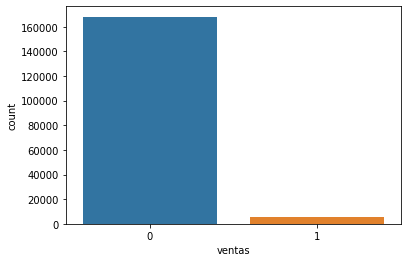

In [88]:
sns.countplot(dataok["ventas"] )

In [117]:
dataok["ventas"].value_counts()

0    168090
1      5236
Name: ventas, dtype: int64

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [110]:
rdf1 = RandomForestClassifier(n_estimators=800)

In [111]:
rdf1.fit(X_train, y_train)

RandomForestClassifier(n_estimators=800)

In [112]:
a = rdf1.predict_proba(X_test)[:,1]

In [103]:
pd.set_option('display.max_rows', 1000) 
pd.set_option('display.min_rows', 500) 

In [113]:
pd.DataFrame(a)

,0
0,0.00000
1,0.00125
2,0.00000
3,0.00000
4,0.99625
5,0.00000
6,1.00000
7,0.00000
8,0.00000
9,0.00000


In [114]:
print(y_test)

fullVisitorID
8743718319993123957    0
3599097241736499812    0
3296716749697415551    0
9013398897531908839    0
0473815800118504130    1
9159550583153011986    0
2191273326752335760    1
3424995112084754222    0
0446328787995215340    0
8480797238234141458    0
0527882661449868883    0
1651412829912395859    0
7818987280263678832    0
3449092118708756125    0
0144685680483925449    0
6634104792355793662    0
9760399376420216635    0
0297021483080191138    0
8874053097214992411    0
9820124750830068778    0
7440317368737529593    0
6067050686303724789    0
6633383499814321043    0
4168835994199858421    0
7566659813270620492    0
3931111539053285001    0
7249396727890934864    0
035665828070937655     0
1568193465567999321    0
4943672858297748788    1
1404896976769026774    0
1387143385011377244    0
7428212237246541943    0
065738113550915690     0
8089470968644878463    0
4436522995396794263    0
2127698906035963392    0
0123775057912176372    0
2431750449626633482    0
63816186197

In [95]:
confusion_matrix(y_test,a)

array([[55427,     0],
       [    0,  1771]])

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.33, random_state=42)
rdf1 = RandomForestClassifier(n_estimators=600)
rdf1.fit(X_train, y_train)
a = rdf1.predict(X_test)
print(classification_report(y_test,a))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     49747
           1       0.29      0.22      0.25      1512

    accuracy                           0.96     51259
   macro avg       0.63      0.60      0.62     51259
weighted avg       0.96      0.96      0.96     51259



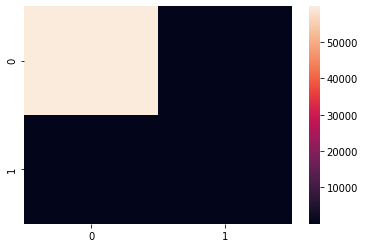

In [133]:
sns.heatmap(confusion_matrix(y_test,a));

In [117]:
data_filt["deviceCategory"].value_counts()

desktop    138562
mobile      50955
tablet       7411
Name: deviceCategory, dtype: int64

## Hyperparameters tuning

Voy a  realizar un random search para optimizar los hiperparámetros del modelo "a groso modo". Luego voy a afinar la búsqueda en el entorno del mejor modelo con un grid search

In [139]:
from sklearn.model_selection import RandomizedSearchCV

In [143]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [144]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rdf1 = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rdf1, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [145]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

<AxesSubplot:xlabel='venta', ylabel='count'>

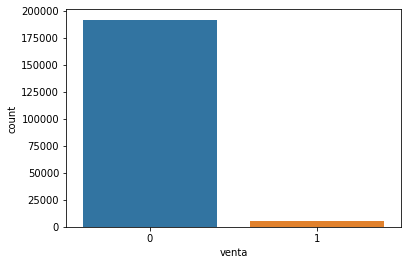

In [121]:
sns.countplot(data=data_filt,x="venta")

In [7]:
fig = px.treemap(data, path=['country'], values='transactions',
                  color_continuous_midpoint=np.average(data['transactions'], weights=data['transactions']))

fig.update_layout(
                  height=600, width=800, margin={"t":40,"b":0,"l":0, "r":0, "pad":0},

                  title={
                        'text': "Total transactions by Country",
                        'y':0.97,
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'},
                )
fig.show()

In [9]:
fig = px.treemap(data, path=['country'], values='transactionRevenue',
                  color_continuous_midpoint=np.average(data['transactionRevenue'], weights=data['transactionRevenue']))

fig.update_layout(
                  height=600, width=800, margin={"t":40,"b":0,"l":0, "r":0, "pad":0},

                  title={
                        'text': "Total Revenue by Country",
                        'y':0.97,
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'},
                )
fig.show()

In [122]:
# Modelo simple de poyección de ventas
ventasxfecha = data[["date","transactionRevenue","transactions"]].dropna()

In [123]:
ventasxfecha["fecha"] = pd.to_datetime(ventasxfecha['date'].apply(lambda x: str(x)[0:4]+"-"+str(x)[4:6]+"-"+str(x)[6:8]))

In [124]:
resumen = ventasxfecha[["fecha","transactions"]].groupby("fecha").sum().reset_index()

In [125]:
resumen.sort_values("transactions", ascending=False)

,fecha,transactions
62,2017-03-04,80.0
120,2017-05-01,78.0
121,2017-05-02,74.0
122,2017-05-03,70.0
47,2017-02-17,69.0
...,...,...
147,2017-05-28,9.0
6,2017-01-07,8.0
104,2017-04-15,7.0
14,2017-01-15,6.0


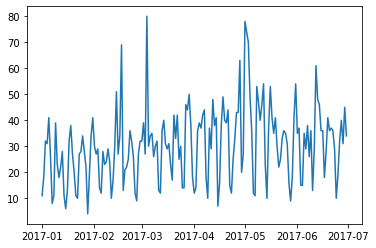

In [127]:
plt.plot(resumen["fecha"],resumen["transactions"])

In [128]:
ventasxmes = ventasxfecha.copy()
ventasxmes["mes"] = ventasxmes['date'].apply(lambda x: str(x)[4:6])
resumen = ventasxmes[["mes","transactions"]].groupby("mes").sum().reset_index()

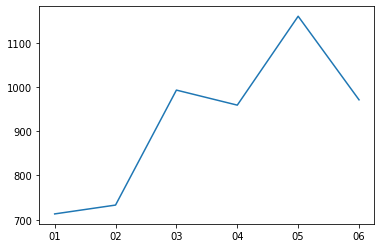

In [129]:
plt.plot(resumen["mes"],resumen["transactions"])